# Per-pixel vegetation phenology in the Ruko Conservancy

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects).


## Description

This notebook will produce **two-dimensional (phenology per-pixel) plot for a given year.**

A number of steps are required to produce the desired outputs:

1. Load satellite data for a region specified by an vector file (shapefile or geojson)
2. Buffer the cloud masking layer to better mask clouds in the data (Sentinel-2 cloud mask is quite poor)
3. Further prepare the data for analysis byt removing bad values (infs), masking surafce water, and removing outliers in the vegetation index.
4. Interpolate and smooth the time-series to ensure a consistent dataset with all gaps and noise removed.
5. Calculate per-pixel phenology statistics
6. Plot the results and export the plot to disk as a .png

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils import geometry

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import map_shapefile
import deafrica_tools.temporal as ts
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.classification import HiddenPrints

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)


## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster(spare_mem='2Gb')

Client Scheduler: tcp://127.0.0.1:40945 Dashboard: /user/victoria@kartoza.com/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 105.37 GB


### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`
* `product`: The satellite product to load. Either Sentinel-2: `'s2_l2a'`, or Landsat-8: `'ls8_cl2'`
* `shapefile`: The path to the vector file delineating the analysis region. Can be a shapefile or a geojson
* `year`: Entire the year to anlayse, e.g. `'2017'`
* `min_gooddata`: the fraction of good data (not cloudy) a scene must have before it is returned as a dataset 
* `resolution`: The pixel resolution, in metres, of the returned dataset
* `dask_chunks`: The size, in number of pixel, for the dask chunks on each dimension.

In [3]:
veg_proxy = 'NDVI'

product = 's2_l2a'

shapefile='data/Ruko_conservancy.geojson'

year = '2018'

resolution = (-20,20)

dask_chunks = {'x':750, 'y':750, 'time':1}


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app='Vegetation_phenology')

## View the region of interest
The next cell will display the selected area on an web map.

In [5]:
#First open the shapefile using geopandas
gdf = gpd.read_file(shapefile)

In [6]:
map_shapefile(gdf, attribute='ConsrvName')

Label(value='')

Map(center=[0.6480841040610879, 36.12258148195494], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

The cell directly below will create a query object using the first geometry in the shapefile, along with the parameters we defined in the Analysis Parameters section above.

In [7]:
# Create a reusable query
geom = geometry.Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)

query = {
    "geopolygon": geom,
    'time': year,
    'measurements': ['red','nir','green','swir_1'],
    'resolution': resolution,
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}


Load available data from S2:

In [8]:
filters=[("opening", 3),("dilation", 2)]

ds = load_ard(
    dc=dc,
    products=['s2_l2a'],
    dask_chunks=dask_chunks,
    mask_filters=filters,
    **query,
)

print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 3), ('dilation', 2)]
Applying pixel quality/cloud mask
Returning 72 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 72, y: 1194, x: 607)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T08:07:58 ... 2018-12-28T08:...
  * y            (y) float64 9.461e+04 9.459e+04 ... 7.077e+04 7.075e+04
  * x            (x) float64 3.479e+06 3.479e+06 ... 3.491e+06 3.491e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 750, 607), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 750, 607), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 750, 607), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 750, 607), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatia

## Mask the satellite data with shape

In [9]:
#create mask
mask = xr_rasterize(gdf,ds)

#mask data
ds = ds.where(mask)

#convert to float 32 to conserve memory
ds=ds.astype(np.float32)

## Calculate vegetation and water indices

In [10]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds, index=[veg_proxy, 'MNDWI'], satellite_mission='s2', drop=True)

Dropping bands ['red', 'nir', 'green', 'swir_1']


## Prepare data for analysis

Remove any NaN or infinite values, mask water, remove any outliers in the vegetation index.  We then reduce the data to a 1D timeseries by calculting the mean across the x and y dimensions.  

This cell will take a couple of minutes to calculate since the `water_mask` needs to be brought into memory (we use this later to mask the phenology results).


In [11]:
# remove any infinite values
ds = ds.where(~np.isinf(ds))

# mask water
ds = ds.where(ds.MNDWI < 0)

#create a all-time water mask for use later
water_mask = ds.MNDWI < 0
water_mask = water_mask.max('time')
water_mask = water_mask.compute()

#remove outliers (if EVI greater than 1.0, set to NaN) 
ds[veg_proxy] = xr.where(ds[veg_proxy]>1.0, np.nan, ds[veg_proxy])
ds[veg_proxy] = xr.where(ds[veg_proxy]<0, np.nan, ds[veg_proxy])

# create 1D line plots
veg = ds[veg_proxy]

## Smooth and interpolate time series

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the SCL layer) the data will be gappy and noisy. Here, we will smooth and interpolate the data to ensure we working with a consistent time-series.

To do this we take two steps:

1. Resample the data to fortnightly time-steps using the median
2. Calculate a rolling mean with a window of 4 steps

These calculations will take several minutes to complete as we will run `.compute()`, triggering all the tasks we scheduled above and bringing the arrays into memory.

In [12]:
resample_period='2W'
window=4

#calculate median first, then bring into memory with .compute()
veg_smooth=veg.resample(time=resample_period, label='left', loffset='1W').median('time')
veg_smooth = veg_smooth.compute()

#calculate rolling mean to smooth time-series
veg_smooth=veg_smooth.rolling(time=window, min_periods=1).mean()

## Compute 2D phenology statistics

Below we specify the statistics to calculate, and the method we'll use for determining the statistics. Options are 'first' & 'median' for `method_sos`, and 'last' & 'median' for `method_eos`.

    method_sos : str 
            If 'first' then vSOS is estimated as the first positive 
            slope on the greening side of the curve. If 'median',
            then vSOS is estimated as the median value of the postive
            slopes on the greening side of the curve.

    method_eos : str
            If 'last' then vEOS is estimated as the last negative slope
            on the senescing side of the curve. If 'median', then vEOS is
            estimated as the 'median' value of the negative slopes on the
            senescing side of the curve.

In [13]:
pheno_stats = ['SOS','vSOS','POS','vPOS','EOS','vEOS','Trough','LOS','AOS','ROG','ROS']
method_sos = 'first'
method_eos = 'last'

In [14]:
with HiddenPrints():
    
    phen=ts.xr_phenology(
            veg_smooth,
            method_sos=method_sos,
            method_eos=method_eos,
            stats=pheno_stats,
                )

print(phen)

<xarray.Dataset>
Dimensions:      (y: 1194, x: 607)
Coordinates:
  * y            (y) float64 9.461e+04 9.459e+04 ... 7.077e+04 7.075e+04
  * x            (x) float64 3.479e+06 3.479e+06 ... 3.491e+06 3.491e+06
    spatial_ref  int32 6933
Data variables:
    SOS          (y, x) int16 365 365 365 365 365 365 ... 365 365 365 365 365
    vSOS         (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    POS          (y, x) int16 365 365 365 365 365 365 ... 365 365 365 365 365
    vPOS         (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    EOS          (y, x) int16 14 14 14 14 14 14 14 14 ... 14 14 14 14 14 14 14
    vEOS         (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Trough       (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LOS          (y, x) int16 13 13 13 13 13 13 13 13 ... 13 13 13 13 13 13 13
    AOS          (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ROG          (y, x) float32

### Re-mask data

The phenology code has methods for handling pixels with only NaNs (such as those regions outside of the polygon mask), so the results can have phenology results for regions over water and outside the mask. We will therefore have to mask the data again.

In [15]:
#mask with polygon
phen = phen.where(mask)

#mask with water-mask
phen = phen.where(water_mask)

## Plot the 2D phenology statistics

The phenology statistics have been calculated seperately for every pixel in the image. Let's plot each of them to see the results.

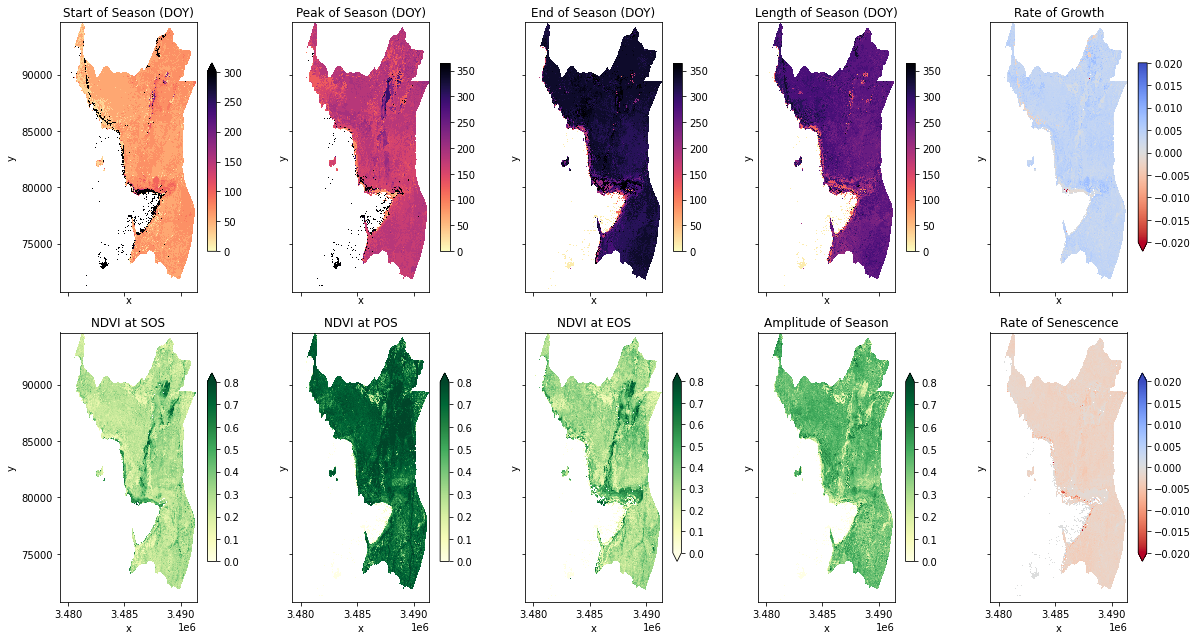

In [16]:
# set up figure
fig, ax = plt.subplots(nrows=2,
                       ncols=5,
                       figsize=(17,9),
                       sharex=True,
                       sharey=True)

# set colorbar size
cbar_size = 0.7

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')

# start of season
phen.SOS.plot(ax=ax[0, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 0].set_title('Start of Season (DOY)')

phen.vSOS.plot(ax=ax[1, 0],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 0].set_title(veg_proxy+' at SOS')

# peak of season
phen.POS.plot(ax=ax[0, 1],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 1].set_title('Peak of Season (DOY)')

phen.vPOS.plot(ax=ax[1, 1],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 1].set_title(veg_proxy+' at POS')

# end of season
phen.EOS.plot(ax=ax[0, 2],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 2].set_title('End of Season (DOY)')
phen.vEOS.plot(ax=ax[1, 2],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 2].set_title(veg_proxy+' at EOS')

# Length of Season
phen.LOS.plot(ax=ax[0, 3],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 3].set_title('Length of Season (DOY)')

# Amplitude
phen.AOS.plot(ax=ax[1, 3],
              cmap='YlGn',
              vmax=0.8,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 3].set_title('Amplitude of Season')

# rate of growth
phen.ROG.plot(ax=ax[0, 4],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 4].set_title('Rate of Growth')

# rate of Sensescence
phen.ROS.plot(ax=ax[1, 4],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 4].set_title('Rate of Senescence')
plt.tight_layout()
plt.savefig('results/phenology_2D_'+year+".png");


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [17]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [18]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-07-07'